<a href="https://colab.research.google.com/github/pk2971/computational-gender-analysis/blob/main/notebooks/Token_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import xml.etree.ElementTree as ET
import re
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter



In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
zip_path = '/content/drive/MyDrive/debates.zip'
# Clean and parse XML text
def extract_text_from_speech(xml_bytes):
  # Extracts and joins all paragraph text from a <speech> XML section
    try:
        root = ET.fromstring(xml_bytes)
        return ' '.join([p.text or '' for p in root.findall('.//speech//p')])
    except ET.ParseError:
        return ""

In [ ]:
def get_year_from_filename(filename):
    match = re.search(r'debates(\d{4})', filename)
    return int(match.group(1)) if match else None


In [ ]:
def collect_documents_by_year(zip_path, start_year, end_year):
  # Reads XML files from a ZIP and aggregates speech text by year
    year_docs = defaultdict(str)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if not file_name.endswith('.xml'):
                continue
            year = get_year_from_filename(file_name)
            if year and start_year <= year <= end_year:
                with zip_ref.open(file_name) as f:
                    xml_bytes = f.read()
                    year_docs[year] += extract_text_from_speech(xml_bytes) + " "
    return year_docs

In [ ]:
def plot_word_importance(zip_path, word, year_input):
  # Plots combined TF-IDF importance of a single word across selected years
    # Parse year range
    if isinstance(year_input, int):
        start_year, end_year = year_input, year_input
    else:
        start_year, end_year = year_input

    # Collect documents by year
    year_docs = collect_documents_by_year(zip_path, start_year, end_year)
    years = sorted(year_docs.keys())
    documents = [year_docs[year] for year in years]

    # TF-IDF Vectorization without stop word removal
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    # Get importance of the word for each year
    word = word.lower()
    if word not in feature_names:
        print(f"'{word}' not found in the vocabulary.")
        return

    word_idx = list(feature_names).index(word)
    importances = tfidf_matrix[:, word_idx].toarray().flatten()

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.plot(years, importances, marker='o', linestyle='-', color='b')
    plt.title(f"TF-IDF Importance of '{word}' from {years[0]} to {years[-1]}")
    plt.xlabel("Year")
    plt.ylabel("TF-IDF Importance")
    plt.grid(True)
    plt.xticks(years)
    plt.show()


In [ ]:
def plot_combined_word_importance(zip_path, words, year_input):
  # Plots combined TF-IDF importance of given words across selected years
    # Parse year range
    if isinstance(year_input, int):
        start_year, end_year = year_input, year_input
    else:
        start_year, end_year = year_input

    # Collect documents by year
    year_docs = collect_documents_by_year(zip_path, start_year, end_year)
    years = sorted(year_docs.keys())
    documents = [year_docs[year] for year in years]

    # TF-IDF Vectorization with stop word removal
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    # Prepare words list
    words = [w.lower() for w in words]
    valid_indices = [i for i, w in enumerate(feature_names) if w in words]
    valid_words = [feature_names[i] for i in valid_indices]

    if not valid_indices:
        print(f"None of the words {words} found in the vocabulary.")
        return

    # Sum importances for the selected words
    importances = tfidf_matrix[:, valid_indices].sum(axis=1).A1  # .A1 flattens to 1D array

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.plot(years, importances, marker='o', linestyle='-', color='b')
    plt.title(f"Combined TF-IDF Importance of {valid_words} from {years[0]} to {years[-1]}")
    plt.xlabel("Year")
    plt.ylabel("Combined TF-IDF Importance")
    plt.grid(True)
    plt.xticks(years)
    plt.show()


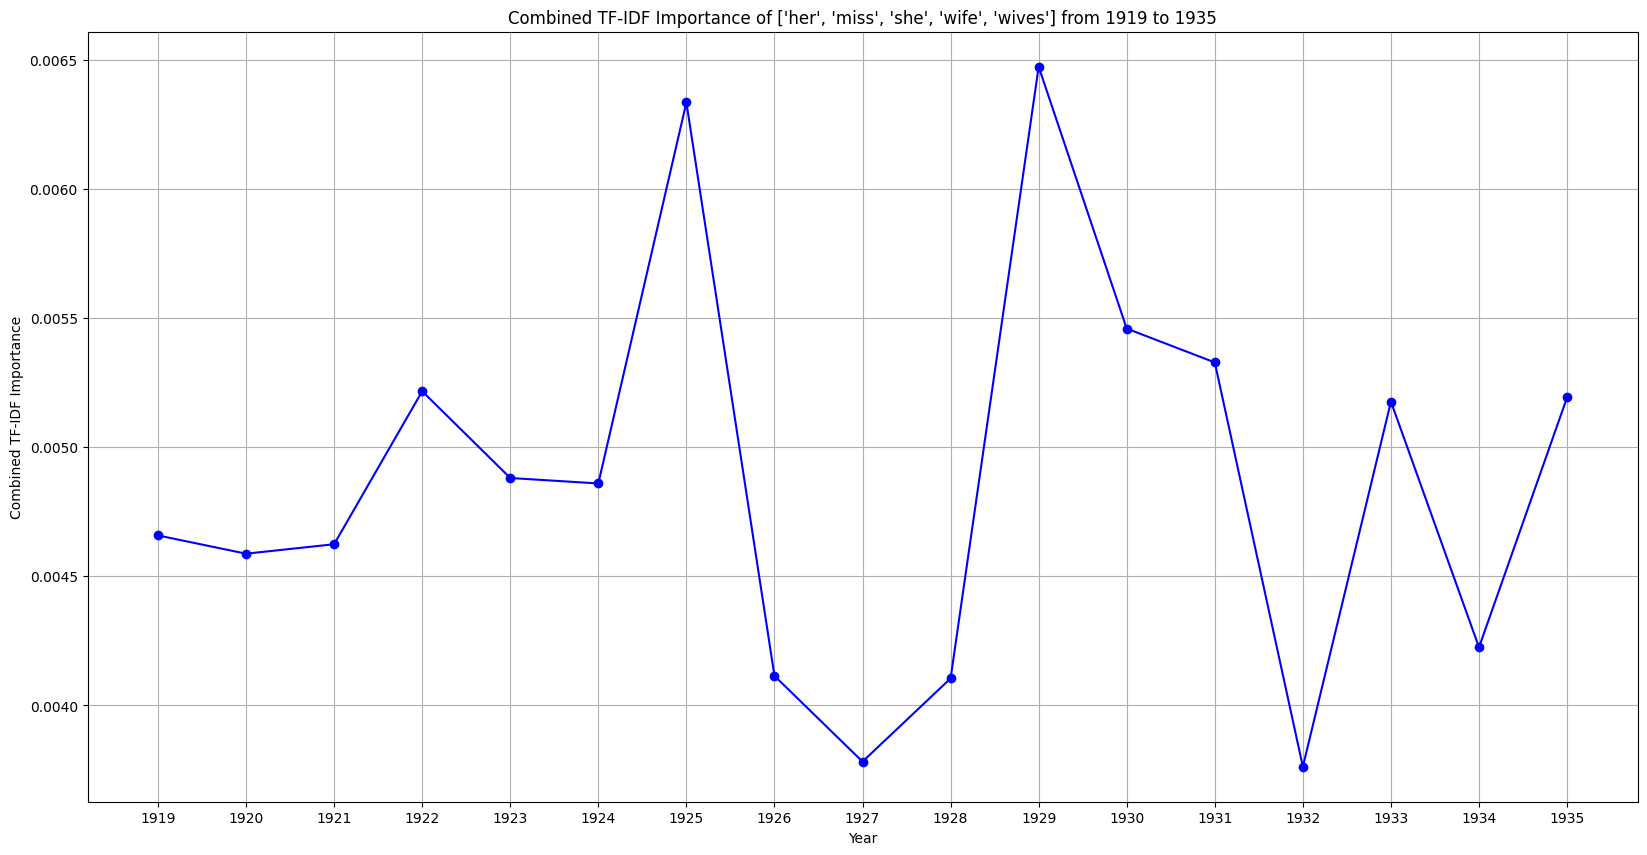

In [ ]:
female_terms = [
    'she', 'her', 'hers',
    'madam speaker', 'madam deputy speaker','madam',
    'miss', 'ms.', 'mrs.',
    'wife','wives','madam',
]
plot_combined_word_importance(zip_path, female_terms, (1919,1935))

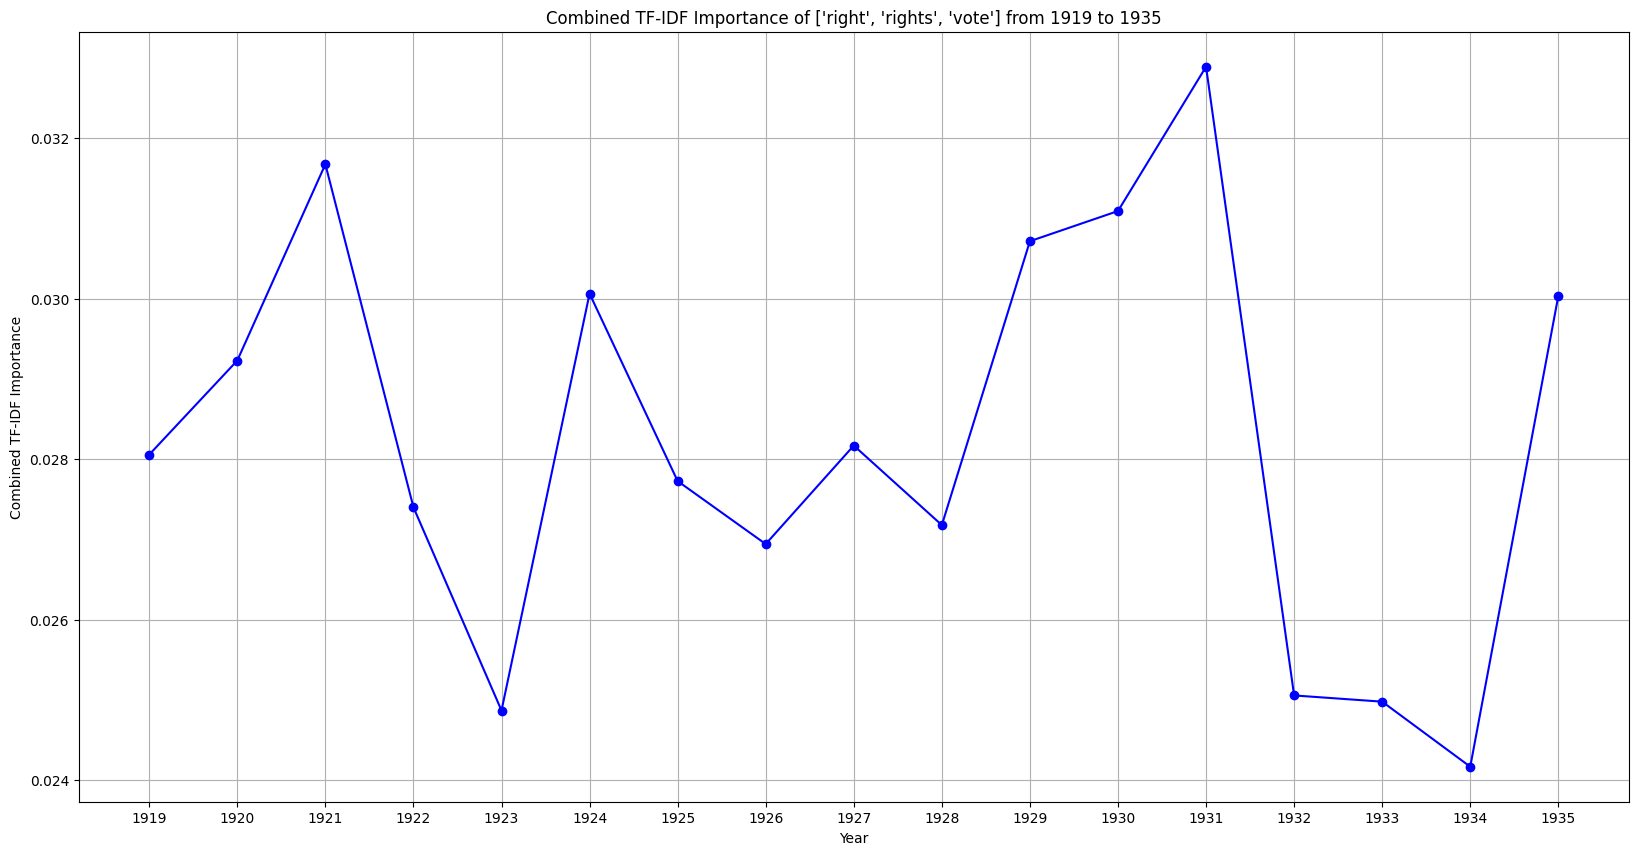

In [ ]:
vote=['vote','suffrage','right','rights']
plot_combined_word_importance(zip_path, vote, (1919,1935))